# Introduction: Expanding market opportunities.

Before expanding into a new city it is important that a a buisness understands the culture of the new market.  In some instances it might be prudent to move into a new city with similar culture, and life styles to cities you currently opperate out of.  This will attract similar employee's to the ones you have and provide similar markety opportunities in a different geographic location.  If your company is seeing sucess in one city expanding into a city with a similar culture could replicate the sucess into a different location.  In other instances a company may be looking to move into a different market.  To find employee's with different values to expand company thinking.  There are always new markets that could be broken into instead of marketing to a subset of potential customers.  In either case it is prudent that a buisness understand the culture of a city and how it compares to other cities in the United States.  Our analysis will leverage the foursquare API to determine the 300 closest venues to the city center of the top 150 US cities (by population).  Using this data we will run a k-means clustering algorith to determine which cities share a similar culture.  The data will then be displayed on an interactive map for easy readability.

## The Data

The Data we will use in this analysis will come from the wikipedia page 
[US cities by population](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population "wikipedia US cities") which lists US cities by population.  From this table we will scrape the top 150 cities by population size, their population density (2016 estimate), longitude and latitude,and change in size (from the 2010 census to the 2018 estimate).  This data will help compare cities based on their size and population.  In addition we will use the longitude and latitude data of each city to call 300 venues within 3 miles from the city center.  This will allow us to do a comparision on the types of venues the local population enjoys as a measure of the local culture.

## Data Gathering process

We first get the list of US cities by population from the wikipedia page.

In [1]:
import urllib.request
import requests

url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
# Get the url
website_url = requests.get(url).text

Now we will look at the JSON code we get in from our request.  We will use beautiful soup to make the JSON easier to read.

In [2]:
from bs4 import BeautifulSoup

#Print out the HTML in a readable format
soup = BeautifulSoup(website_url, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of United States cities by population - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_United_States_cities_by_population","wgTitle":"List of United States cities by population","wgCurRevisionId":924763995,"wgRevisionId":924763995,"wgArticleId":1649321,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Wikipedia indefinitely semi-protected pages","Use mdy dates from August 2014","Lists of coordinates","Geographic coordinate lists","Articles with Geo","Featured lists","Cities in the United States","Lists of cities in the United States by population","United States demography-related lists","Demographics by city in the United States"],"wgBrea

In the JSON file we extract the table element.

In [3]:
#Find the table elements
My_table = soup.find('table',{'class': 'wikitable sortable'})
My_table

<table class="wikitable sortable" style="text-align:center">
<tbody><tr>
<th>2018<br/>rank
</th>
<th>City
</th>
<th>State<sup class="reference" id="cite_ref-5"><a href="#cite_note-5">[c]</a></sup>
</th>
<th>2018<br/>estimate
</th>
<th>2010<br/>Census
</th>
<th>Change
</th>
<th colspan="2">2016 land area
</th>
<th colspan="2">2016 population density
</th>
<th>Location
</th></tr>
<tr>
<td>1
</td>
<td style="text-align:left;background-color:#cfecec"><i><a href="/wiki/New_York_City" title="New York City">New York</a></i><sup class="reference" id="cite_ref-6"><a href="#cite_note-6">[d]</a></sup>
</td>
<td align="left"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="450" data-file-width="900" decoding="async" height="12" src="//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_New_York.svg/23px-Flag_of_New_York.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_New_York.svg/35px-Flag_of_New_York.svg.png 1.5x, //upload.wikimedia.org/w

The information we are looking for is in the field <td>.  Using this information we can extract the cities data.

In [4]:
cities = My_table.findAll('td')
cities

[<td>1
 </td>,
 <td style="text-align:left;background-color:#cfecec"><i><a href="/wiki/New_York_City" title="New York City">New York</a></i><sup class="reference" id="cite_ref-6"><a href="#cite_note-6">[d]</a></sup>
 </td>,
 <td align="left"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="450" data-file-width="900" decoding="async" height="12" src="//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_New_York.svg/23px-Flag_of_New_York.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_New_York.svg/35px-Flag_of_New_York.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_New_York.svg/46px-Flag_of_New_York.svg.png 2x" width="23"/> </span><a href="/wiki/New_York_(state)" title="New York (state)">New York</a>
 </td>,
 <td style="text-align:right;">8,398,748
 </td>,
 <td style="text-align:right;">8,175,133
 </td>,
 <td style="text-align:right;"><span data-sort-value="7000274000000000000♠" style="display:none"></

We will use pandas to create a pandas data frame of our city data.  The cities data will be placed into a new data frame called city_info.

In [5]:
import pandas as pd #Import Pandas

#Create a blank data frame to put wikipedia table into
city_info = pd.DataFrame(columns = ['city', 'population', 'population density', 'change in size', 'lon and lat'])



num_cities = 0 #Keeps track of the number of cities.
count = 0  #Keeps count of where in the row the for loop is in the data.
empty_list = []
add_row = []
Useful_Entries = [1,3,8,5,10] #The row index for city, population, population density, change in size, and longitude and latitude

#The loop populates the city_info dataframe.  
for city in cities:
    empty_list.append(city.get_text().rstrip())
    count = count + 1
    if count%11 == 0 and count != 0:
        for i in Useful_Entries:
            add_row.append(empty_list[i])
        city_info.loc[len(city_info)] = add_row
        empty_list = []
        add_row = []
        num_cities = num_cities +1
        if city_info.city.nunique() == 150:
            break         

#View the city_info data to check for accuracy.
city_info.head()

city population population density change in size  \
0  New York[d]  8,398,748       28,317/sq mi         +2.74%   
1  Los Angeles  3,990,456        8,484/sq mi         +5.22%   
2      Chicago  2,705,994       11,900/sq mi         +0.39%   
3   Houston[3]  2,325,502        3,613/sq mi        +10.72%   
4      Phoenix  1,660,272        3,120/sq mi        +14.85%   

                                         lon and lat  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...

In [6]:
# We check there are 150 cities in the data frame
city_info.city.nunique()

150

### Cleaning the data

We now need to clean our city_info data frame to make the data useable. To do this we will use the regular expressions package.  First we remove indicators in the city column attached to the city name (i.e. 'New York[d]' will be corrected to 'New York').

In [7]:
import re

column = [] #Create a empty list for a column

# Loop through city entries, find any elements inside brackes [], and replace them with a space
for city in city_info['city']:
    column.append(re.sub("[\(\[].*?[\)\]]", "", city))

# Replace the city column with our new column
city_info['city'] = column
city_info.head()  #Check to see our change worked    

city population population density change in size  \
0     New York  8,398,748       28,317/sq mi         +2.74%   
1  Los Angeles  3,990,456        8,484/sq mi         +5.22%   
2      Chicago  2,705,994       11,900/sq mi         +0.39%   
3      Houston  2,325,502        3,613/sq mi        +10.72%   
4      Phoenix  1,660,272        3,120/sq mi        +14.85%   

                                         lon and lat  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...

Now we want to make population density into an integer and strip the "/sq mi" from the value.

In [8]:
column = [] #Create an empty list for a column.

# Loop through entries in population density column removes /sq mi, removes commas, and converts the info into an integer
for density in city_info['population density']:
    column.append(int(density.strip('/sq\xa0mi').replace(',','')))
    
    
city_info['population density'] = column #Update population density column
city_info.head() #Check changes

city population  population density change in size  \
0     New York  8,398,748               28317         +2.74%   
1  Los Angeles  3,990,456                8484         +5.22%   
2      Chicago  2,705,994               11900         +0.39%   
3      Houston  2,325,502                3613        +10.72%   
4      Phoenix  1,660,272                3120        +14.85%   

                                         lon and lat  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...

We now reformat the change in size value from a string with a percent symbol to a float value.  We notice cities with negative growth need to be changed into '-' to properly be converted into float values.

In [9]:
# Get the negative character in the table
neg = city_info[city_info['city'] == 'Detroit'].iloc[0]['change in size'][0]

column = [] #Create an empty list for our column.
#Loop through change in size to replace the addition, change to float value, fix the negative and replace %
for change in city_info['change in size']:
    column.append(float(change.replace("+", "").replace("%", "").replace(neg, '-')))

city_info['change in size'] = column #Replace change in size column
city_info.head() #Check changes

city population  population density  change in size  \
0     New York  8,398,748               28317            2.74   
1  Los Angeles  3,990,456                8484            5.22   
2      Chicago  2,705,994               11900            0.39   
3      Houston  2,325,502                3613           10.72   
4      Phoenix  1,660,272                3120           14.85   

                                         lon and lat  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...

We now remove the comma's from population and change the type to integers.

In [10]:
column = [] #create an empty list for our column

#Loop through population column to convert the string to into a integer and remove commas.
for pop in city_info['population']:
    column.append(int(pop.replace(',', '')))

city_info['population'] = column #Update the population column
city_info.head()  #Check changes

city  population  population density  change in size  \
0     New York     8398748               28317            2.74   
1  Los Angeles     3990456                8484            5.22   
2      Chicago     2705994               11900            0.39   
3      Houston     2325502                3613           10.72   
4      Phoenix     1660272                3120           14.85   

                                         lon and lat  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...

The last task for cleaing this data frame is to turn the lon and lat column into two seperate columns containing float values rather than strings.

In [11]:
latitude = [] #Create empty list for new latitude column
longitude = [] #Create empty list for new longitude column

#Loop through lon and lat data and extract the data.
for coord in city_info['lon and lat']:
    #pull out numbers in text
    num = re.findall('/ (.*?)\ufeff', coord)[1]
    #seperate lon and lat
    latitude.append(re.findall('(.*?);' , num)[0].strip())
    longitude.append(re.findall('(?:;)(.*)', num)[0].strip())
    #num = ''

city_info['latitude'] = latitude  #Create a latitude column
city_info['longitude'] = longitude #Create a longitude column

city_info.head() #Check the new columns

city  population  population density  change in size  \
0     New York     8398748               28317            2.74   
1  Los Angeles     3990456                8484            5.22   
2      Chicago     2705994               11900            0.39   
3      Houston     2325502                3613           10.72   
4      Phoenix     1660272                3120           14.85   

                                         lon and lat latitude  longitude  
0  40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...  40.6635   -73.9387  
1  34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...  34.0194  -118.4108  
2  41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...  41.8376   -87.6818  
3  29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...  29.7866   -95.3909  
4  33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...  33.5722  -112.0901

We remove the lon and lat column because it is no longer needed.

In [12]:
del city_info['lon and lat']
city_info.head()  #Check the data frame

city  population  population density  change in size latitude  \
0     New York     8398748               28317            2.74  40.6635   
1  Los Angeles     3990456                8484            5.22  34.0194   
2      Chicago     2705994               11900            0.39  41.8376   
3      Houston     2325502                3613           10.72  29.7866   
4      Phoenix     1660272                3120           14.85  33.5722   

   longitude  
0   -73.9387  
1  -118.4108  
2   -87.6818  
3   -95.3909  
4  -112.0901

In [33]:
city_info

city  population  population density  change in size  \
0            New York     8398748               28317            2.74   
1         Los Angeles     3990456                8484            5.22   
2             Chicago     2705994               11900            0.39   
3             Houston     2325502                3613           10.72   
4             Phoenix     1660272                3120           14.85   
5        Philadelphia     1584138               11683            3.81   
6         San Antonio     1532233                3238           15.43   
7           San Diego     1425976                4325            9.07   
8              Dallas     1345047                3866           12.29   
9            San Jose     1030119                5777            8.90   
10             Austin      964254                3031           22.00   
11       Jacksonville      903889                1178            9.99   
12         Fort Worth      895008                2491           20.75   
13           Columbus      892533                3936           13.40   
14      San Francisco      883305               18569            9.70   
15          Charlotte      872498                2757           19.29   
16       Indianapolis      867125                2366            5.69   
17            Seattle      744955                8405           22.39   
18             Denver      716492                4521           19.38   
19         Washington      702455               11148           16.74   
20             Boston      694583               13938           12.47   
21            El Paso      682669                2660            5.17   
22            Detroit      672662                4847           -5.76   
23          Nashville      669053                1388           11.28   
24           Portland      653115                4793           11.88   
25            Memphis      650618                2056            0.58   
26      Oklahoma City      649021                1053           11.90   
27          Las Vegas      644644                4709           10.43   
28         Louisville      620118                2339            3.81   
29          Baltimore      602495                7598           -2.97   
30          Milwaukee      592025                6186           -0.47   
31        Albuquerque      560218                2972            2.63   
32             Tucson      545975                2299            4.97   
33             Fresno      530093                4563            7.16   
34               Mesa      508958                3514           15.92   
35         Sacramento      508529                5059            9.01   
36            Atlanta      498044                3539           18.58   
37        Kansas City      491918                1528            6.99   
38   Colorado Springs      472688                2378           13.51   
39              Miami      470914               12599           17.89   
40            Raleigh      469298                3163           16.19   
41              Omaha      468262                3356           14.50   
42         Long Beach      467354                9347            1.10   
43     Virginia Beach      450189                1850            2.78   
44            Oakland      429082                7514            9.82   
45        Minneapolis      425403                7660           11.19   
46              Tulsa      400669                2048            2.24   
47          Arlington      398112                4100            8.94   
48              Tampa      392890                3326           17.03   
49        New Orleans      391006                2311           13.72   
50            Wichita      389255                2431            1.80   
51          Cleveland      383793                4965           -3.28   
52        Bakersfield      383579                2529           10.39   
53             Aurora      374114                2356           15.08   
54

### Getting 4-square data for the analysis.

For our analysis we will need the numpy package, requests, and json to parse through the 4-square data.  We also import matplot lib, scilearn, and folium to perform the analysis and visualize the data.

In [13]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

#If folium is not on your machine uncoment the next line
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


The following will create a map of the united states to map out the cities in our analysis.

In [14]:
# create map of New York using latitude and longitude values
map_us = folium.Map(location=[48, -102], zoom_start=3)

# add markers to map
for lat, lng, city, pop in zip(city_info['latitude'], city_info['longitude'], city_info['city'], city_info['population']):
    label = '{}, {}'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  

    
map_us.save("us_map.html")

To acess the Foursquare data we will need to use our client ID and credentials.

In [15]:
CLIENT_ID = 'ARJBUSFHFC0AXGZAHDGMV1G00DCDTMFJQIKRP4PTKQTHAT3L' # your Foursquare ID
CLIENT_SECRET = 'DA3PIG23EJPASMTEW41PTR2Q3Q0G4AVQ1TNEUPJRLRD0RBH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 250 #The limitng number of responses per request.

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ARJBUSFHFC0AXGZAHDGMV1G00DCDTMFJQIKRP4PTKQTHAT3L
CLIENT_SECRET:DA3PIG23EJPASMTEW41PTR2Q3Q0G4AVQ1TNEUPJRLRD0RBH4


The following function extracts the venue category type from Foursquare json data.  This function will be used to determine what the venue category is of each response from Foursquares API.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'city latitude', 
                  'city longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

We now use the above function to get the venues for our list of cities.

In [17]:
city_venues = getNearbyVenues(names=city_info['city'],
                                   latitudes=city_info['latitude'],
                                   longitudes=city_info['longitude']
                                  )

New York
Los Angeles
Chicago
Houston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin
Jacksonville
Fort Worth
Columbus
San Francisco
Charlotte
Indianapolis
Seattle
Denver
Washington
Boston
El Paso
Detroit
Nashville
Portland
Memphis
Oklahoma City
Las Vegas
Louisville
Baltimore
Milwaukee
Albuquerque
Tucson
Fresno
Mesa
Sacramento
Atlanta
Kansas City
Colorado Springs
Miami
Raleigh
Omaha
Long Beach
Virginia Beach
Oakland
Minneapolis
Tulsa
Arlington
Tampa
New Orleans
Wichita
Cleveland
Bakersfield
Aurora
Anaheim
Honolulu
Santa Ana
Riverside
Corpus Christi
Lexington
Stockton
Henderson
Saint Paul
St. Louis
Cincinnati
Pittsburgh
Greensboro
Anchorage
Plano
Lincoln
Orlando
Irvine
Newark
Toledo
Durham
Chula Vista
Fort Wayne
Jersey City
St. Petersburg
Laredo
Madison
Chandler
Buffalo
Lubbock
Scottsdale
Reno
Glendale
Gilbert
Winston–Salem
North Las Vegas
Norfolk
Chesapeake
Garland
Irving
Hialeah
Fremont
Boise
Richmond
Baton Rouge
Spokane
Des Moines
Tacoma
San Bernardino
Modesto
Fontan

We now take a look at the shape of the data gathered in the city_venues data frame.

In [18]:
print(city_venues.shape)
city_venues.head()

(10364, 7)


city city latitude city longitude                       venue  \
0  New York       40.6635       -73.9387  Izzy's Brooklyn Smokehouse   
1  New York       40.6635       -73.9387             Ali's Roti Shop   
2  New York       40.6635       -73.9387           Sweet Expressions   
3  New York       40.6635       -73.9387               Empanada City   
4  New York       40.6635       -73.9387    Little Mo Wine & Spirits   

   venue latitude  venue longitude        venue category  
0       40.664869       -73.937023             BBQ Joint  
1       40.666436       -73.931346  Caribbean Restaurant  
2       40.668382       -73.942337           Candy Store  
3       40.661631       -73.950436   Empanada Restaurant  
4       40.660346       -73.950360          Liquor Store

Let us determine the number of unique categories of venues.

In [19]:
print('There are {} uniques categories.'.format(len(city_venues['venue category'].unique())))

There are 431 uniques categories.


We will now make a data frame called city_onehot containing all of the venue categories with the one hot encoding method.

In [20]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['city'] = city_venues['city'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

city  ATM  Accessories Store  Advertising Agency  Afghan Restaurant  \
0  New York    0                  0                   0                  0   
1  New York    0                  0                   0                  0   
2  New York    0                  0                   0                  0   
3  New York    0                  0                   0                  0   
4  New York    0                  0                   0                  0   

   African Restaurant  Airport  Airport Service  Airport Terminal  \
0                   0        0                0                 0   
1                   0        0                0                 0   
2                   0        0                0                 0   
3                   0        0                0                 0   
4                   0        0                0                 0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium  Arcade  \
0                    0               0             0         0       0   
1                    0               0             0         0       0   
2                    0               0             0         0       0   
3                    0               0             0         0       0   
4                    0               0             0         0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  Astrologer  \
0                    0                     0                 0           0   
1                    0                     0                 0           0   
2                    0                     0                 0           0   
3                    0                     0                 0           0   
4                    0                     0                 0           0   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                   0                      0                    0   
1                   0                      0                    0   
2                   0                      0                    0   
3                   0                      0                    0   
4                   0                      0                    0   

   Auto Dealership  Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  \
0                0            0                0          1           0   
1                0            0                0          0           0   
2                0            0                0          0           0   
3                0            0                0          0           0   
4                0            0                0          0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     0    0               0                 0                 0   
2       0     0    0               0                 0                 0   
3       0     0    0               0                 0                 0   
4       0     0    0               0                 0                 0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                   0      0                0         0            0   
1                   0      0                0         0            0   
2                   0      0                0         0            0   
3                   0      0                0         0            0   
4                   0      0                0         0            0   

   Beer Store  Big B

Lets group rows by city and find the percentage of each category of venue.  We will do this in the data frame city_grouped.

In [21]:
city_grouped = city_onehot.groupby('city').mean().reset_index()
print(city_grouped.shape)
city_grouped

(145, 432)


city       ATM  Accessories Store  Advertising Agency  \
0               Akron  0.000000           0.000000            0.000000   
1         Albuquerque  0.000000           0.000000            0.000000   
2            Amarillo  0.000000           0.000000            0.000000   
3             Anaheim  0.000000           0.000000            0.000000   
4           Arlington  0.000000           0.000000            0.000000   
5             Atlanta  0.000000           0.000000            0.000000   
6             Augusta  0.000000           0.000000            0.000000   
7              Aurora  0.000000           0.000000            0.000000   
8              Austin  0.000000           0.000000            0.000000   
9         Bakersfield  0.000000           0.000000            0.000000   
10          Baltimore  0.000000           0.000000            0.000000   
11        Baton Rouge  0.000000           0.000000            0.000000   
12         Birmingham  0.000000           0.000000            0.000000   
13              Boise  0.020202           0.000000            0.000000   
14             Boston  0.000000           0.000000            0.000000   
15        Brownsville  0.000000           0.000000            0.000000   
16            Buffalo  0.000000           0.000000            0.000000   
17         Cape Coral  0.000000           0.000000            0.000000   
18           Chandler  0.000000           0.000000            0.000000   
19          Charlotte  0.000000           0.000000            0.000000   
20        Chattanooga  0.000000           0.000000            0.000000   
21            Chicago  0.000000           0.000000            0.000000   
22        Chula Vista  0.000000           0.000000            0.000000   
23         Cincinnati  0.010000           0.000000            0.000000   
24          Cleveland  0.000000           0.000000            0.000000   
25   Colorado Springs  0.020408           0.000000            0.000000   
26           Columbus  0.000000           0.000000            0.000000   
27             Dallas  0.000000           0.000000            0.000000   
28             Denver  0.010000           0.010000            0.000000   
29         Des Moines  0.000000           0.000000            0.000000   
30            Detroit  0.000000           0.000000            0.000000   
31             Durham  0.000000           0.000000            0.000000   
32            El Paso  0.000000           0.000000            0.000000   
33          Elk Grove  0.000000           0.000000            0.000000   
34       Fayetteville  0.000000           0.000000            0.000000   
35            Fontana  0.000000           0.000000            0.000000   
36    Fort Lauderdale  0.000000           0.000000            0.000000   
37         Fort Wayne  0.000000           0.000000            0.000000   
38         Fort Worth  0.000000           0.000000            0.000000   
39            Fremont  0.000000           0.000000            0.000000   
40             Fresno  0.000000           0.000000            0.000000   
41             Frisco  0.000000           0.000000            0.000000   
42       Garden Grove  0.000000           0.000000            0.000000   
43            Garland  0.000000           0.000000            0.000000   
44            Gilbert  0.000000           0.011628            0.000000   
45           Glendale  0.010870           0.000000            0.000000   
46      Grand Prairie  0.000000           0.000000            0.000000   
47       Grand Rapids  0.000000           0.000000            0.000000   
48         Greensboro  0.000000           0.010000            0.000000   
49          Henderson  0.000000           0.000000            0.000000   
50            Hialeah  0.000000           0.000000            0.000000   
51           Honolulu  0.000000           0.000000            0.000000   
52            Houston  0.000000           0.000000            0.000000   
53   Huntington Beach

We will also find the top 10 venues in each city as a data frame.  We can do this by creating a function which finds the most popular venues.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['city'] = city_grouped['city']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

city 1st Most Common Venue     2nd Most Common Venue  \
0        Akron        Sandwich Place                       Bar   
1  Albuquerque               Brewery                     Hotel   
2     Amarillo  Fast Food Restaurant                     Hotel   
3      Anaheim        Sandwich Place  Mediterranean Restaurant   
4    Arlington        Sandwich Place        Mexican Restaurant   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0  Fast Food Restaurant            Coffee Shop   American Restaurant   
1           Coffee Shop             Restaurant  Fast Food Restaurant   
2    Mexican Restaurant            Gas Station   American Restaurant   
3           Coffee Shop                  Trail         Grocery Store   
4  Fast Food Restaurant  Vietnamese Restaurant          Burger Joint   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Rental Car Location           Music Venue                  Bank   
1    Mexican Restaurant           Gas Station          Burger Joint   
2        Sandwich Place            Restaurant      Sushi Restaurant   
3   American Restaurant    Mexican Restaurant                  Bank   
4  Gym / Fitness Center              Pharmacy   Fried Chicken Joint   

  9th Most Common Venue 10th Most Common Venue  
0                  Café             Restaurant  
1        Discount Store         Sandwich Place  
2                  Bank                  Motel  
3            Donut Shop         Clothing Store  
4           Gas Station       Sushi Restaurant

We want to add the scalled data into our data grouped data data frame for population, population density, and change in size.

In [24]:
scaled_df = city_info[['city', 'population', 'population density', 'change in size']]
float_array = scaled_df[['population', 'population density', 'change in size']] #This contains the numeric data of scaled_df

cols_to_norm = ['population', 'population density', 'change in size']
#This gets us the columns we need to normalize

min_max_scaler = preprocessing.MinMaxScaler() #Initialize the min max scaler
scaled_df[cols_to_norm] = min_max_scaler.fit_transform(scaled_df[cols_to_norm])
scaled_df.head()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Nathan\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


city  population  population density  change in size
0     New York    1.000000            1.000000        0.127628
1  Los Angeles    0.464134            0.295253        0.164865
2      Chicago    0.307997            0.416637        0.092342
3      Houston    0.261745            0.122166        0.247447
4      Phoenix    0.180881            0.104648        0.309459

The results data frame will merge the cities_grouped data frame to add in our population and change in size data.

In [25]:
result = pd.merge(city_grouped,
                 scaled_df,
                 right_on = 'city',
                 left_on = 'city',
                 how = 'left')
result.head()

city  ATM  Accessories Store  Advertising Agency  Afghan Restaurant  \
0        Akron  0.0                0.0                 0.0                0.0   
1  Albuquerque  0.0                0.0                 0.0                0.0   
2     Amarillo  0.0                0.0                 0.0                0.0   
3      Anaheim  0.0                0.0                 0.0                0.0   
4    Arlington  0.0                0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Service  Airport Terminal  \
0                 0.0      0.0              0.0               0.0   
1                 0.0      0.0              0.0               0.0   
2                 0.0      0.0              0.0               0.0   
3                 0.0      0.0              0.0               0.0   
4                 0.0      0.0              0.0               0.0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium  Arcade  \
0             0.040000             0.0           0.0       0.0     0.0   
1             0.032258             0.0           0.0       0.0     0.0   
2             0.058824             0.0           0.0       0.0     0.0   
3             0.042254             0.0           0.0       0.0     0.0   
4             0.010000             0.0           0.0       0.0     0.0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0.0                     0.0     0.020000        0.01   
1               0.0                     0.0     0.000000        0.00   
2               0.0                     0.0     0.014706        0.00   
3               0.0                     0.0     0.000000        0.00   
4               0.0                     0.0     0.000000        0.00   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  Astrologer  \
0             0.000000                   0.0              0.01         0.0   
1             0.016129                   0.0              0.00         0.0   
2             0.000000                   0.0              0.00         0.0   
3             0.000000                   0.0              0.00         0.0   
4             0.000000                   0.0              0.01         0.0   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                 0.0                    0.0                  0.0   
1                 0.0                    0.0                  0.0   
2                 0.0                    0.0                  0.0   
3                 0.0                    0.0                  0.0   
4                 0.0                    0.0                  0.0   

   Auto Dealership  Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  \
0              0.0          0.0              0.0   0.000000        0.01   
1              0.0          0.0              0.0   0.000000        0.00   
2              0.0          0.0              0.0   0.014706        0.00   
3              0.0          0.0              0.0   0.014085        0.00   
4              0.0          0.0              0.0   0.010000        0.00   

     Bakery      Bank   Bar  Baseball Field  Baseball Stadium  \
0  0.000000  0.030000  0.05            0.00              0.01   
1  0.016129  0.016129  0.00            0.00              0.00   
2  0.000000  0.029412  0.00            0.00              0.00   
3  0.014085  0.028169  0.00            0.00              0.00   
4  0.010000  0.010000  0.00            0.02              0.00   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Garden  Beer Store  Big Box Store

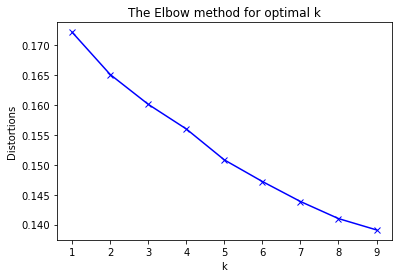

In [26]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


distortions = []
city_grouped_clustering = city_grouped.drop('city', 1)

K = range(1,10)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(city_grouped_clustering)
    kmeanModel.fit(city_grouped_clustering)
    distortions.append(sum(np.min(cdist(city_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / city_grouped_clustering.shape[0])
                        
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow method for optimal k')
plt.show()

We can see from teh graph above there is an 'elbow' (or knee) at k = 6.  Therefore we will use 6 different clusters in our analysis.
We will now run the k-means clustering algorith to classify our cities.

In [27]:
# set number of clusters
kclusters = 6

city_grouped_clustering = city_grouped.drop('city', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 4, 4, 0, 4, 1, 0])

In [28]:
# add clustering labels
#del city_venues_sorted['Cluster Labels']
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [29]:
city_merged = city_info

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('city'), on='city')

city_merged.head() # check the last columns!

city  population  population density  change in size latitude  \
0     New York     8398748               28317            2.74  40.6635   
1  Los Angeles     3990456                8484            5.22  34.0194   
2      Chicago     2705994               11900            0.39  41.8376   
3      Houston     2325502                3613           10.72  29.7866   
4      Phoenix     1660272                3120           14.85  33.5722   

   longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0   -73.9387             1.0  Caribbean Restaurant                  Café   
1  -118.4108             1.0           Pizza Place           Coffee Shop   
2   -87.6818             4.0    Mexican Restaurant        Sandwich Place   
3   -95.3909             1.0    Mexican Restaurant           Pizza Place   
4  -112.0901             4.0                  Park     Convenience Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery             Juice Bar          Cocktail Bar   
1         Grocery Store    Mexican Restaurant       Thai Restaurant   
2           Supermarket            Taco Place         Grocery Store   
3        Ice Cream Shop   American Restaurant                  Park   
4    Mexican Restaurant        Discount Store   Fried Chicken Joint   

  6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0                   Bar      Sushi Restaurant              Pizza Place   
1            Taco Place                   Gym                     Café   
2    Italian Restaurant           Coffee Shop            Hot Dog Joint   
3           Art Gallery                  Café  New American Restaurant   
4                  Café  Fast Food Restaurant                   Bakery   

       9th Most Common Venue 10th Most Common Venue  
0          Indian Restaurant              Wine Shop  
1           Sushi Restaurant           Burger Joint  
2       Gym / Fitness Center                  Diner  
3  Cajun / Creole Restaurant                 Bistro  
4                Coffee Shop               Pharmacy

Using this data we will create a map to visualize the cities colored by their clustering.

In [30]:
# create map
map_clusters = folium.Map(location=[48, -120], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['latitude'], city_merged['longitude'], city_merged['city'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    try:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster-1)],
            fill=True,
            fill_color=rainbow[int(cluster-1)],
            fill_opacity=0.7).add_to(map_clusters)
    except:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color= 'grey',
            fill=True,
            fill_color= 'grey',
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('us_clusters.html')